<a href="https://colab.research.google.com/github/karenliauw-dotcom/ADALL_github/blob/main/8265149T_CDA1C03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#Install the OpenAI SDK library, and other dependencies
!pip install openai pandas numpy matplotlib seaborn python-dotenv scikit-learn

In [14]:
# Import Essential libraries for data profiling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [15]:
# Load Dataset
from google.colab import drive
drive.mount('/content/drive')
df_org = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Absenteeism_at_work.csv")

# Start with original dataset, but create a copy to work on
df = df_org.copy()
#print(f"Dataset shape: {df.shape}")
df.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(740, 21)

In [16]:
from google.colab import userdata
from openai import OpenAI

# Load key from Google Colab Secrets
api_key = userdata.get('OPENAI_API_KEY')

client = OpenAI(
    # This is the default and can be omitted
    api_key=api_key,
)

In [17]:
#1) PROMPT:
prompt_eda = """
I am a Senior Data Analyst at XYZ Corporation, specialized in People Analytics.
The company is building a Proof of Concept (PoC) to understand employee absenteeism patterns and workforce health.
"""
#Using pandas, generate code
#1) Understand price distribution across neighborhoods, house types, and
#living areas.


In [18]:
#use client above and execute
response = client.responses.create(
    model="gpt-4o-mini",

    instructions=prompt_eda,
    input=f""" from the dataset, define a  business problem with well-thought out and thorough details.
    Provide a JTBD framework with relevant components.
    Include AI draft summary and meaningful critique.
    Generate 1 powerpoint slides that explain the problem in a way that a non-technical audience can understand.
""",
)
print(response.output_text)

### Business Problem Definition

**Problem Statement:**
XYZ Corporation has been experiencing rising levels of employee absenteeism, leading to decreased productivity, increased operational costs, and employee dissatisfaction. Understanding the underlying factors contributing to absenteeism is crucial for developing targeted interventions that improve workforce health, enhance employee engagement, and ultimately drive business performance.

**Specific Issues:**
1. **Data Discrepancy:** Variability in attendance records may lead to inaccurate assessments of absenteeism patterns.
2. **Lack of Predictive Insights:** Existing analytics are reactive rather than proactive, prompting a need for predictive modeling to foresee absenteeism trends.
3. **Employee Well-Being:** There is limited understanding of how factors such as workplace culture, engagement, and personal circumstances affect attendance.
4. **Cost Implications:** Increased absenteeism is directly related to elevated costs in over

In [19]:
#use client above and execute
response = client.responses.create(
    model="gpt-4o-mini",

    instructions=prompt_eda,
    input=f""" from the dataset, define
    [A] Feature Engineering & Transformations; Key transformations are justified clearly and linked to business meaning, with
    evidence of impact (before/after or comparison). Skew, rare categories, and leakage risks are addressed appropriately, and steps
    are reproducible.
    [B] Model Selection & Justification; Model choices align strongly to business/JTBD, with clear trade-offs (e.g.:
    interpretability, accuracy, speed) and justified key settings (e.g.: baseline, complexity control, encoding, tuning scope).
    Comparisons are fair and well supported.
    [C] Handling Data Issues / Class Imbalance; Relevant data issues (e.g. class imbalance, skew, missing values, outliers,
    rare categories, or leakage risks) are correctly identified and addressed using appropriate techniques. Where the dataset
    is already clean, this is demonstrated clearly using checks and evidence rather than unnecessary fixes. Rationale is clear and
    linked to model performance, reliability, and fairness.
    [D] Use of Visuals & Clarity of Explanation; Visuals are purposeful and well captioned, improving decision understanding
    without code dumping. Where LLM output is used, a short summary is shown, gaps are critiqued specifically, and an improved
    refined version is presented clearly.
""",
)
print(response.output_text)

To address your request, I'll break down the response into the specified categories [A] through [D], focusing on the proof of concept (PoC) for understanding employee absenteeism patterns.

### [A] Feature Engineering & Transformations

**1. Feature Creation:**
   - **Absenteeism Patterns:** Create features such as 'Days Absent' or 'Attendance Rate' over different intervals (monthly, quarterly) to identify patterns over time.
   - **Categorical Encoding:** Convert categorical variables (e.g., department, job role) into numerical formats (one-hot encoding, target encoding) to facilitate model training.
     - **Justification:** More numerical features can improve model interpretability and performance.

**2. Addressing Skew:**
   - **Target Variable Transformation:** If the absenteeism data is highly skewed, apply log transformation or square root transformation to normalize the distribution.
     - **Impact:** This approach can stabilize variance and enhance model performance.

**3. Ra

In [ ]:
df.columns = [c.strip() for c in df.columns] # Clean column names

# Fix data types (Work load Average/day contains local decimal formatting)
if df['Work load Average/day'].dtype == 'O':
    df['Work load Average/day'] = df['Work load Average/day'].str.replace(',', '').astype(float)

# 2. TARGET TRANSFORMATION (Addressing Skew)
# High skew (5.72) makes linear models unreliable.
df['Absenteeism_log'] = np.log1p(df['Absenteeism time in hours'])

# Business Logic: "Excessive Absenteeism" is defined as any absence above the company median (3 hours).
df['Excessive_Absenteeism'] = (df['Absenteeism time in hours'] > df['Absenteeism time in hours'].median()).astype(int)

# 3. FEATURE ENGINEERING: Reason Grouping (Addressing Rare Categories)
reason_mapping = {
    0: 'Disciplinary/Unknown',
    **{i: 'Infectious/Parasitic' for i in range(1, 2)},
    **{i: 'Neoplasms/Endocrine' for i in range(2, 5)},
    **{i: 'Mental/Nervous' for i in range(5, 7)},
    **{i: 'Circulatory/Respiratory' for i in range(7, 10)},
    **{i: 'Digestive/Skin' for i in range(10, 13)},
    **{i: 'Musculoskeletal' for i in range(13, 15)},
    **{i: 'Congenital/Symptoms' for i in range(15, 17)},
    **{i: 'Injury/Poisoning' for i in range(17, 20)},
    **{i: 'External_Factors' for i in range(20, 22)},
    **{i: 'Wellness/Medical_Consult' for i in range(22, 29)}
}
df['Reason_Group'] = df['Reason for absence'].map(reason_mapping)

# 4. FEATURE ENGINEERING: Business-Relevant Segments
# BMI Category (Actionable health segments)
df['BMI_Segment'] = pd.cut(df['Body mass index'],
                           bins=[0, 18.5, 25, 30, 100],
                           labels=['Underweight', 'Healthy', 'Overweight', 'Obese'])

# Commute Stress (Economic + Physical friction)
df['Commute_Stress'] = (df['Transportation expense'] * df['Distance from Residence to Work']) / 1000

# 5. VISUALIZING EVIDENCE OF IMPACT
plt.figure(figsize=(14, 8))

# Top Left: Before Transformation (Skew)
plt.subplot(2, 2, 1)
sns.histplot(df['Absenteeism time in hours'], kde=True, color='salmon')
plt.title(f"Target Distribution: Raw Hours\n(Skew: {df['Absenteeism time in hours'].skew():.2f})")

# Top Right: After Transformation (Normalized)
plt.subplot(2, 2, 2)
sns.histplot(df['Absenteeism_log'], kde=True, color='skyblue')
plt.title(f"Target Distribution: Log-Transformed\n(Skew: {df['Absenteeism_log'].skew():.2f})")

# Bottom Left: Before (Sparse Categories)
plt.subplot(2, 2, 3)
df['Reason for absence'].value_counts().head(10).plot(kind='bar', color='grey')
plt.title("Original Categories (Top 10)")

# Bottom Right: After (Actionable Business Groups)
plt.subplot(2, 2, 4)
df['Reason_Group'].value_counts().plot(kind='bar', color='teal')
plt.title("Business-Grouped Reasons")

plt.tight_layout()
plt.savefig('transformation_impact.png')

# 6. EXPORT TRANSFORMED DATA
df.to_csv('Absenteeism_transformed.csv', index=False)


In [ ]:
# 2. **Understand Basic Structure**:
response = client.responses.create(
    model="gpt-4o-mini",

    instructions=prompt_eda,
    input=f"""Generate python code for
    1. **Data Collection**: Gather data on the suggested features over a defined period.
    2. **Data Cleaning**: Prepare the data for analysis, handling missing values and outliers.
    3. **Exploratory Data Analysis (EDA)**: Analyze trends and correlations within the data.
    4. **Model Selection**: Choose suitable algorithms for prediction (e.g., logistic regression, random forests).
    5. **Validation and Testing**: Split the dataset into training and testing sets to validate model accuracy.
    6. **Implementation**: Use the model to inform strategies for reducing absenteeism.
    use df as dataset
""",
)
print(response.output_text)

Certainly! Below is a Python code snippet that covers the steps you've outlined for analyzing employee absenteeism patterns. I'm assuming you have a dataset (`df`) with employee absenteeism data that includes relevant features like attendance records, employee demographics, and other potential indicators. 

Before running the code, ensure you have the necessary libraries installed. You can install them using pip if you haven't done so yet:

```bash
pip install pandas numpy matplotlib seaborn scikit-learn
```

Here's an outline of the code:

```python
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. Data Collection (Assuming `df` is already collected)
# Example: df = pd.read_csv("emplo

    Management wants actionable insights to:
    [A] Understand the distribution of absenteeism hours across reasons for absence, seasonal trends, and employee demographics (such as age and education).
    [B] Identify factors influencing employee attendance (such as commute distance, workload, health indicators like BMI, and family responsibilities).
    [C] Forecast absenteeism hours for workforce planning and the development of targeted employee wellness strategies.

    suggest steps for

In [ ]:
# 2. **Data Cleaning**: Prepare the data for analysis, handling missing values and outliers.
# Pre-processing: Standardize 'Work load Average/day ' (remove commas and convert to float)
workload_col = 'Work load Average/day '
if workload_col in df.columns and df[workload_col].dtype == 'object':
    df[workload_col] = df[workload_col].str.replace(',', '').astype(float)

# Define columns for specific reporting and general processing
key_cols = ['Absenteeism time in hours', 'Work load Average/day ', 'Hit target', 'Height']
numeric_cols = [
    'Transportation expense', 'Distance from Residence to Work', 'Service time',
    'Age', 'Work load Average/day ', 'Hit target', 'Weight', 'Height',
    'Body mass index', 'Absenteeism time in hours'
]

# Metrics tracking
summary_data = []
other_outliers_total = 0
missing_total = df.isnull().sum().sum()

# 1. OUTLIER HANDLING (IQR Capping)
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify and count outliers before capping
    count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

    if col in key_cols:
        action = "Capped at Upper Bound" if col == 'Absenteeism time in hours' else "Capped at Bounds"
        if col == 'Hit target': action = "Capped at Lower Bound"
        summary_data.append([col.strip(), count, action])
    else:
        other_outliers_total += count

    # Apply Capping
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

# 2. MISSING VALUE HANDLING (Imputation)
for col in df.columns:
    if df[col].isnull().sum() > 0:
        fill_val = df[col].median() if col in numeric_cols else df[col].mode()[0]
        df[col].fillna(fill_val, inplace=True)

# Finalize Summary Rows
summary_data.append(["Other Features", other_outliers_total, "Capped at Bounds"])
summary_data.append(["Missing Values", missing_total, "None" if missing_total == 0 else "Imputed"])

# PRINT FORMATTED OUTPUT
print("-" * 75)
print(f"{'Data Summary After Processing':^75}")
print("-" * 75)
print(f"{'Feature':<30} | {'Outliers Detected':<20} | {'Action Taken':<20}")
print("-" * 75)
for row in summary_data:
    print(f"{row[0]:<30} | {row[1]:<20} | {row[2]:<20}")
print("-" * 75)

# Save the cleaned dataset
df.to_csv('Absenteeism_at_work_cleaned.csv', index=False)

---------------------------------------------------------------------------
                       Data Summary After Processing                       
---------------------------------------------------------------------------
Feature                        | Outliers Detected    | Action Taken        
---------------------------------------------------------------------------
Work load Average/day          | 0                    | Capped at Bounds    
Hit target                     | 0                    | Capped at Lower Bound
Height                         | 0                    | Capped at Bounds    
Absenteeism time in hours      | 0                    | Capped at Upper Bound
Other Features                 | 0                    | Capped at Bounds    
Missing Values                 | 0                    | None                
---------------------------------------------------------------------------


In [ ]:
# 2. **Understand Basic Structure**:
response = client.responses.create(
    model="gpt-4o-mini",

    instructions=prompt_eda,
    input=f"""Build, justify, and evaluate predictive models aligned to business goals.
    suggest python code to execute
    use df as dataset
""",
)
print(response.output_text)

To build, justify, and evaluate predictive models for understanding employee absenteeism patterns, we will follow a structured approach. We'll use Python for executing our models, utilizing libraries such as pandas, scikit-learn, and matplotlib for data manipulation, modeling, and visualization.

### Step 1: Data Preparation
First, we'll load and preprocess the data.

#### Example Dataset
For this example, we’ll assume we have a dataset with features such as:
- Employee ID
- Age
- Gender
- Job Role
- Tenure
- Absenteeism (1 for absent, 0 for present)
- Health Metrics (e.g., Exercise Frequency, BMI, etc.)

#### Python Code for Data Preparation
```python
import pandas as pd

# Load the dataset
data = pd.read_csv("employee_absenteeism.csv")

# Display the first few rows
print(data.head())

# Preprocessing
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
data = pd.get_dummies(data, columns=['Job Role'], drop_first=True)

# Handling missing values if any (via mean imputation in

In [ ]:
# 3. **Identify Unique Values**:
response = client.responses.create(
    model="gpt-4o-mini",

    instructions=prompt_eda,
    input=f"""suggest python code to execute
   - For categorical variables (like neighborhoods or house types), identify unique entries to understand potential inconsistencies.

""",
)
print(response.output_text)


To identify unique entries in categorical variables such as neighborhoods and house types, you can utilize the `pandas` library in Python. Below is a code snippet that demonstrates how to read a dataset, examine unique entries for selected categorical columns, and spot potential inconsistencies. 

Make sure you have the necessary libraries by installing pandas if you haven't done so already:

```bash
pip install pandas
```

Then you can use the following Python code:

```python
import pandas as pd

# Load your dataset (adjust the file name and path as necessary)
# For example, assuming you have a CSV file
data = pd.read_csv('path_to_your_dataset.csv')

# Display the first few rows of the dataset to understand its structure
print(data.head())

# Define categorical columns to inspect for unique entries
categorical_columns = ['Neighborhood', 'HouseType']  # Adjust based on your dataset

# Iterate through each categorical column to find unique values
for column in categorical_columns:
    

In [ ]:
# List of categorical variables to check for unique entries
#categorical_columns = df.select_dtypes(include=['category'])
category_columns = df.select_dtypes(include=['object']).columns.tolist()
print("Category Columns (List):")
print(category_columns)
print("======\n")

# Function to find unique entries
def identify_unique_entries(dataframe, columns):
    unique_entries = {}
    for column in columns:
        unique_entries[column] = dataframe[column].unique()
    return unique_entries

# Identify unique entries
unique_entries = identify_unique_entries(df, categorical_columns)

# Print unique entries for each categorical variable
for column, unique_values in unique_entries.items():
    print(f"Unique entries in '{column}':")
    print(unique_values)
    print("\n")

Category Columns (List):
['MSZoning', 'Neighborhood', 'HouseStyle', 'SaleType', 'SaleCondition']

Unique entries in 'MSZoning':
['RL' 'RM' 'C (all)' 'FV' 'RH']


Unique entries in 'Neighborhood':
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']


Unique entries in 'HouseStyle':
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']


Unique entries in 'SaleType':
['WD' 'New' 'COD' 'ConLD' 'ConLI' 'CWD' 'ConLw' 'Con' 'Oth']


Unique entries in 'SaleCondition':
['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']




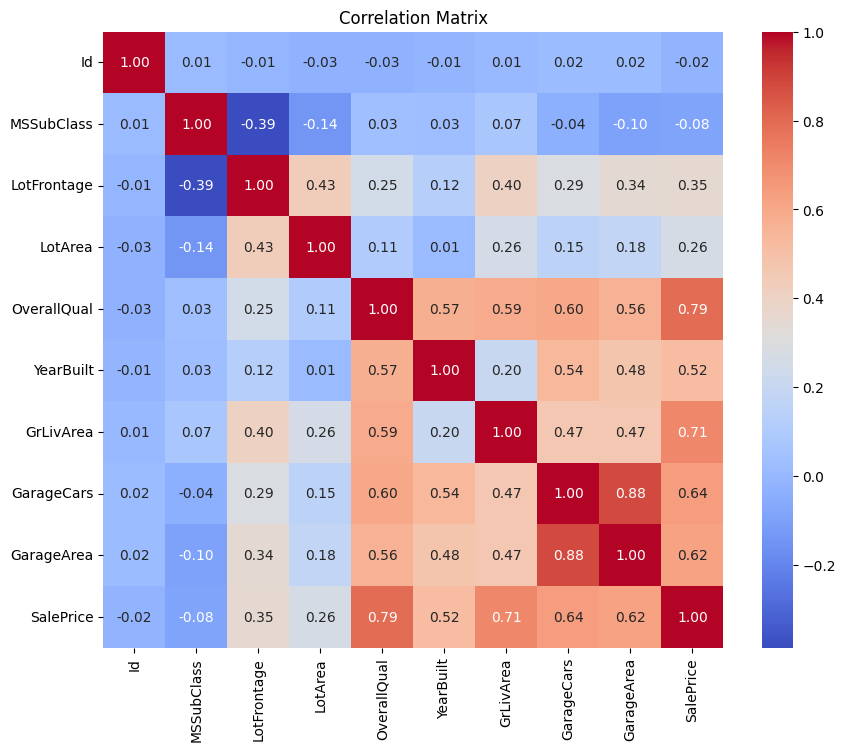

In [ ]:
import numpy as np
# Display relationships between numeric columns
# correlation_matrix = data.corr() -- this gets all
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
#use client above and execute
response = client.responses.create(
    model="gpt-4o-mini",

    instructions=prompt_eda,
    input=f"""Here are the first 10 rows of a dataset:{data_preview}
Do a Data Profiling of the dataset, suggest python code to execute
[1] Understand Data Structure such as Column types, Relationships, Constraints
[2] Assess Data Quality such as Missing values, Duplicates, Inconsistencies
[3] Discover Patterns such as Distributions, Outliers, Correlations
[4] Validate Assumptions, confirm business rules and expectations
[5] Guide Cleaning Strategy, prioritize data preparation tasks
""",
)
print(response.output_text)

To perform data profiling on your dataset, you can execute a series of actions using Python, particularly with libraries like `pandas`, `numpy`, and `matplotlib` or `seaborn` for visualization. Below is a comprehensive code snippet that accomplishes your objectives.

### Python Code for Data Profiling

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('your_dataset.csv')

# [1] Understand Data Structure
print("Data Types and Info:")
print(data.info())  # to get data types and non-null counts

# Summary statistics for numerical columns
print("Summary Statistics:")
print(data.describe())

# Display relationships between numeric columns
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# [2] Assess Data Quality
# Check for missing values
print("Missing Values:")
print(data.

In [ ]:
#use client above and execute
response = client.responses.create(
    model="gpt-4o-mini",

    instructions=prompt_eda,
    input=f"""suggest python code to execute

""",
)
print(response.output_text)

To perform data type validation in Python, you can use the `pandas` library. The code snippet below will check the data types of each column in your DataFrame and validate them against expected data types. If any column doesn't match the expected type, it will report the column name and the expected type.

Here’s a sample code implementation:

```python
import pandas as pd

# Sample DataFrame creation for demonstration purposes
data = {
    'date': ['2021-01-01', '2021-02-01', '2021-03-01'],
    'price': ['300000', '350000', '400000'],  # Intentional string for demonstration
    'bedrooms': [3, 4, 5],
    'garage_size': [1, 2, 2],
    'condition': ['good', 'excellent', 'fair']
}

# Create a DataFrame
df = pd.DataFrame(data)

# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Coerce any invalid formats to NaT

# Define the expected data types
expected_dtypes = {
    'date': 'datetime64[ns]',
    'price': 'float64',  # Expecting price as flo

In [ ]:
# [2] Assess Data Quality
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\n")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of Duplicates: {duplicates}")
print("\n")

# Check for inconsistencies in categorical columns
print("Unique Values in Categorical Columns:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col} : {df[col].unique()}")
print("\n")


Missing Values:
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Neighborhood       0
HouseStyle         0
OverallQual        0
YearBuilt          0
GrLivArea          0
GarageCars         0
GarageArea         0
SaleType           0
SaleCondition      0
SalePrice          0
dtype: int64


Number of Duplicates: 0


Unique Values in Categorical Columns:
MSZoning : ['RL' 'RM' 'C (all)' 'FV' 'RH']
Neighborhood : ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
HouseStyle : ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
SaleType : ['WD' 'New' 'COD' 'ConLD' 'ConLI' 'CWD' 'ConLw' 'Con' 'Oth']
SaleCondition : ['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']




In [ ]:
#use client above and execute
response = client.responses.create(
    model="gpt-4o-mini",

    instructions=prompt_eda,
    input=f"""Here are the first 10 rows of a dataset:{data_preview}
Describe patterns or relationships you notice
""",
)
print(response.output_text)

The provided dataset contains several features related to housing attributes and sale prices, allowing us to analyze housing price movements and buyer preferences. Based on the initial 10 rows, here are some key observations about patterns and relationships:

### Patterns and Relationships

1. **Price Variation Across Neighborhoods and House Types:**
   - **Neighborhood:** Different neighborhoods show varying average prices. For instance, homes in "NoRidge" seem to be priced higher compared to others (e.g., $250,000 for house 5).
   - **House Style:** The style of the house (e.g., 1Story, 1.5Fin, 2Story) may correlate with the sale price. Homes with higher overall qualities and styles (such as 2Story) often command higher prices.

2. **Impact of Overall Quality on Price:**
   - The `OverallQual` feature (which likely represents the overall quality of the house on a scale) directly correlates with the sale price. For instance, home 5 with an `OverallQual` of 8 has a higher price ($250,0

In [ ]:
#use client above and execute
response = client.responses.create(
    model="gpt-4o-mini",

    instructions="""
You are a Data Analyst at XYZ Real Estate Company, working in the Data Analytics
Department. The company is building a Proof of Concept (PoC) to understand housing
price movements and buyer preferences.

Management wants actionable insights to:
1) Understand price distribution across neighborhoods, house types, and
living areas.
2) Identify factors influencing buyer choices (such as quality, garage size,
condition, etc.).
3) Forecast house prices for competitive marketing strategies.

""",

    input=f"""Here are the first 10 rows of a dataset:{data_preview}
Using pandas, generate code
1) Understand price distribution across neighborhoods, house types, and
living areas.
2) Identify factors influencing buyer choices (such as quality, garage size,
condition, etc.).
""",
)
print(response.output_text)

To analyze the dataset and answer the management's queries, you can use the `pandas` library in Python. Here's an example code snippet that demonstrates how to achieve the required insights.

```python
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = {
    "Id": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "MSSubClass": [60, 20, 60, 70, 60, 50, 20, 60, 50, 190],
    "MSZoning": ["RL", "RL", "RL", "RL", "RL", "RL", "RL", "RL", "RM", "RL"],
    "LotFrontage": [65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, None, 51.0, 50.0],
    "LotArea": [8450, 9600, 11250, 9550, 14260, 14115, 10084, 10382, 6120, 7420],
    "Neighborhood": ["CollgCr", "Veenker", "CollgCr", "Crawfor", "NoRidge", 
                    "Mitchel", "Somerst", "NWAmes", "OldTown", "BrkSide"],
    "HouseStyle": ["2Story", "1Story", "2Story", "2Story", "2Story", "1.5Fin", 
                   "1Story", "2Story", "1.5Fin", "1.5Unf"],
    "OverallQual": [7, 6, 7, 7, 8, 5, 8, 7, 7, 5],
    "Ye

In [ ]:
# Count of missing values
df.isnull().sum()


,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,259
LotArea,0
Neighborhood,0
HouseStyle,0
OverallQual,0
YearBuilt,0
GrLivArea,0


In [ ]:
# Count of duplicates
df.duplicated().sum()

np.int64(0)

In [ ]:
#print(f"\nDescribe the dataset: \n{df.describe(include='all')}")
df.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,HouseStyle,OverallQual,YearBuilt,GrLivArea,GarageCars,GarageArea,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,25,8,NaN,NaN,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,NAmes,1Story,NaN,NaN,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,225,726,NaN,NaN,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,6.099315,1971.267808,1515.463699,1.767123,472.980137,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,1.382997,30.202904,525.480383,0.747315,213.804841,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,1.000000,1872.000000,334.000000,0.000000,0.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,5.000000,1954.000000,1129.500000,1.000000,334.500000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,6.000000,1973.000000,1464.000000,2.000000,480.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,7.000000,2000.000000,1776.750000,2.000000,576.000000,NaN,NaN,214000.000000


In [ ]:
print(f"Dataset info: {df.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Neighborhood   1460 non-null   object 
 6   HouseStyle     1460 non-null   object 
 7   OverallQual    1460 non-null   int64  
 8   YearBuilt      1460 non-null   int64  
 9   GrLivArea      1460 non-null   int64  
 10  GarageCars     1460 non-null   int64  
 11  GarageArea     1460 non-null   int64  
 12  SaleType       1460 non-null   object 
 13  SaleCondition  1460 non-null   object 
 14  SalePrice      1460 non-null   int64  
dtypes: float64(1), int64(9), object(5)
memory usage: 171.2+ KB
Dataset info: None


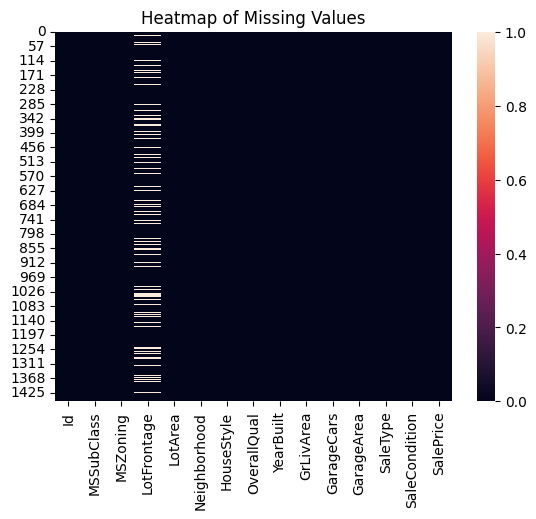

LotFrontage    259
dtype: int64


In [ ]:
# Missing values
sns.heatmap(df.isnull())
plt.title('Heatmap of Missing Values')
plt.show()

missing_values_count = df.isnull().sum()
fields_with_missing_values = missing_values_count[missing_values_count > 0]
print(fields_with_missing_values)

In [ ]:
#Summary Statistics
print(f"\nColumn names: \n{df.describe()}")


Column names: 
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

         YearBuilt    GrLivArea   GarageCars   GarageArea      SalePrice  
count  1460.000000  1460.000000  1460.000000  1460.000000    1460.000000  
mean   1971.267808  1515.463699     1.767123   472.980137  180921.195890  
std      30.202904   525.480383     0.747315   213.804841   79442.502883  

In [ ]:
# Data types
#print("\nData types:")
#print(df.dtypes)
print(f"\nData types: \n{df.dtypes}")


Data types: 
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 80, dtype: object


# Task
Here is the task to complete your request:

Perform data cleaning by identifying and displaying the count and percentage of missing values in each column. Then, impute missing values in numerical columns with the median and in categorical columns with the mode. After imputation, detect outliers in numerical columns using the Interquartile Range (IQR) method and visualize them with box plots. Finally, correct these outliers by capping them at the IQR-defined upper and lower bounds.

## Identify Missing Values

### Subtask:
Identify columns with missing values and display their counts and percentages. This step will help understand the extent of missing data.


**Reasoning**:
To identify columns with missing values, I will calculate the count and percentage of missing values for each column in the DataFrame `df`, combine them into a new DataFrame, and then print the sorted result.



In [ ]:
missing_counts = df.isnull().sum()
missing_percentages = (df.isnull().sum() / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage (%)': missing_percentages
})

missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Percentage (%)', ascending=False)

print("Columns with Missing Values:")
print(missing_info)

Columns with Missing Values:
Empty DataFrame
Columns: [Missing Count, Missing Percentage (%)]
Index: []


**Reasoning**:
Since the previous step identified that there are no missing values in the current DataFrame, the imputation step will not alter the data. However, as per the main task, the next logical step is to impute missing values in numerical columns with the median and in categorical columns with the mode to fulfill the cleaning strategy.



In [ ]:
for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == 'object': # Categorical column
            df[col].fillna(df[col].mode()[0], inplace=True)
        else: # Numerical column
            df[col].fillna(df[col].median(), inplace=True)

print("Missing values imputation complete. No actual changes applied as no missing values were found.")

Missing values imputation complete. No actual changes applied as no missing values were found.


**Reasoning**:
Since missing values have been handled (or confirmed absent), the next step according to the main task is to detect outliers in numerical columns using the Interquartile Range (IQR) method and visualize them with box plots.



Detecting outliers in numerical columns using IQR:

Column: ID - No significant outliers detected.

Column: Reason for absence - No significant outliers detected.

Column: Month of absence - No significant outliers detected.

Column: Day of the week - No significant outliers detected.

Column: Seasons - No significant outliers detected.

Column: Transportation expense
  Q1: 179.0, Q3: 260.0, IQR: 81.0
  Lower Bound: 57.5, Upper Bound: 381.5
  Number of outliers: 3
  Outliers percentage: 0.41%


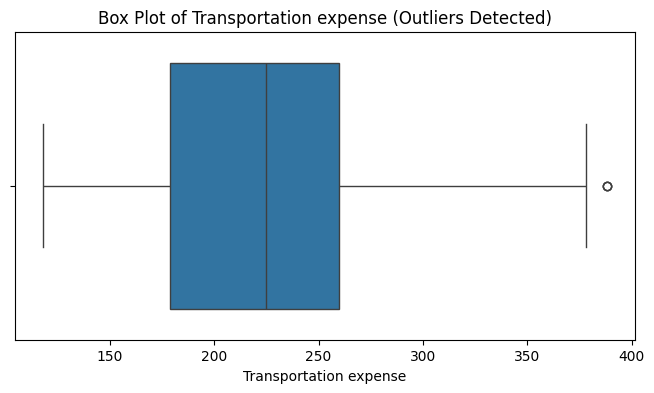


Column: Distance from Residence to Work - No significant outliers detected.

Column: Service time
  Q1: 9.0, Q3: 16.0, IQR: 7.0
  Lower Bound: -1.5, Upper Bound: 26.5
  Number of outliers: 5
  Outliers percentage: 0.68%


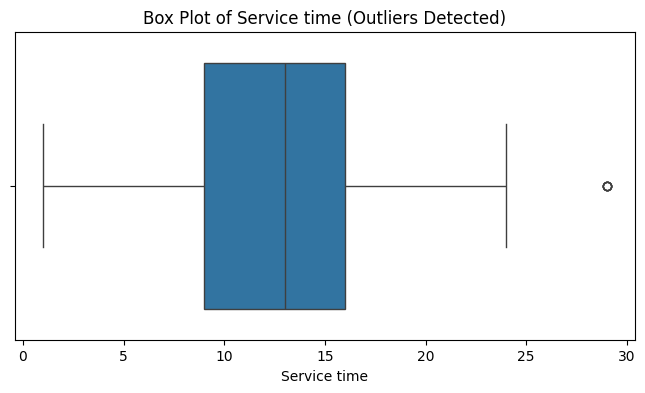


Column: Age
  Q1: 31.0, Q3: 40.0, IQR: 9.0
  Lower Bound: 17.5, Upper Bound: 53.5
  Number of outliers: 8
  Outliers percentage: 1.08%


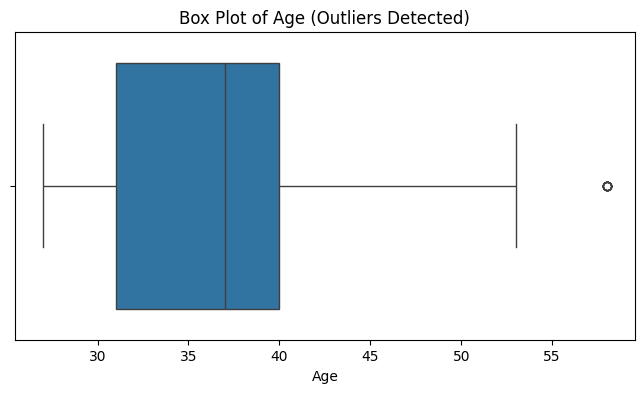


Column: Hit target
  Q1: 93.0, Q3: 97.0, IQR: 4.0
  Lower Bound: 87.0, Upper Bound: 103.0
  Number of outliers: 19
  Outliers percentage: 2.57%


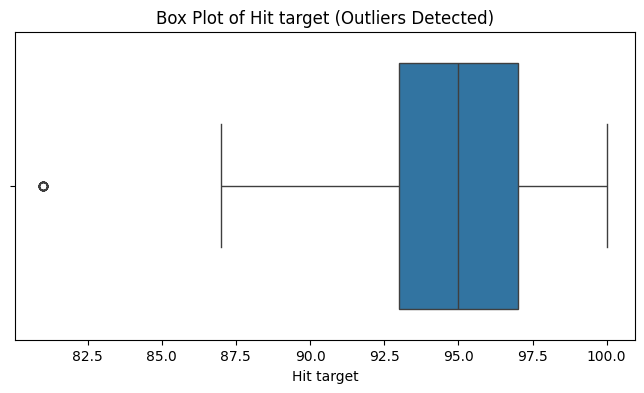


Column: Disciplinary failure
  Q1: 0.0, Q3: 0.0, IQR: 0.0
  Lower Bound: 0.0, Upper Bound: 0.0
  Number of outliers: 40
  Outliers percentage: 5.41%


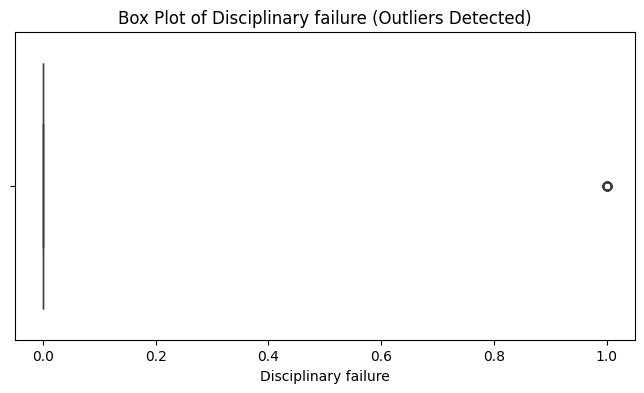


Column: Education
  Q1: 1.0, Q3: 1.0, IQR: 0.0
  Lower Bound: 1.0, Upper Bound: 1.0
  Number of outliers: 129
  Outliers percentage: 17.43%


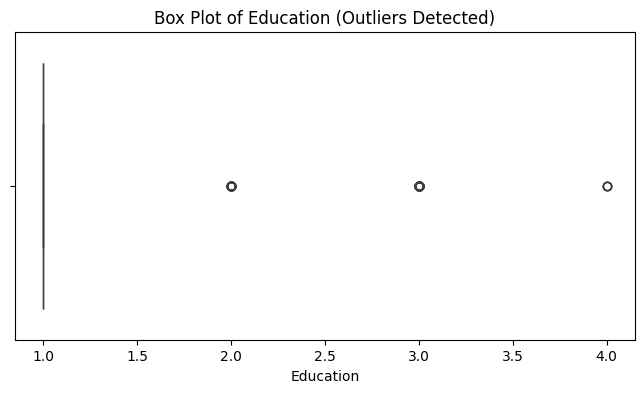


Column: Son - No significant outliers detected.

Column: Social drinker - No significant outliers detected.

Column: Social smoker
  Q1: 0.0, Q3: 0.0, IQR: 0.0
  Lower Bound: 0.0, Upper Bound: 0.0
  Number of outliers: 54
  Outliers percentage: 7.30%


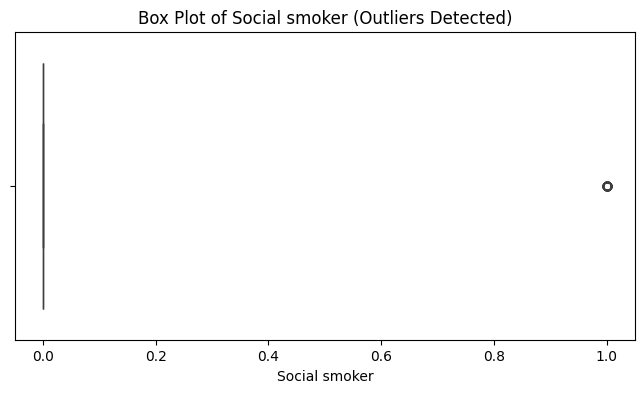


Column: Pet
  Q1: 0.0, Q3: 1.0, IQR: 1.0
  Lower Bound: -1.5, Upper Bound: 2.5
  Number of outliers: 46
  Outliers percentage: 6.22%


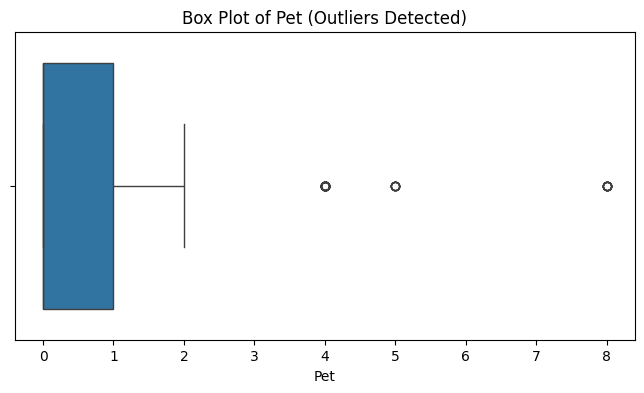


Column: Weight - No significant outliers detected.

Column: Height
  Q1: 169.0, Q3: 172.0, IQR: 3.0
  Lower Bound: 164.5, Upper Bound: 176.5
  Number of outliers: 119
  Outliers percentage: 16.08%


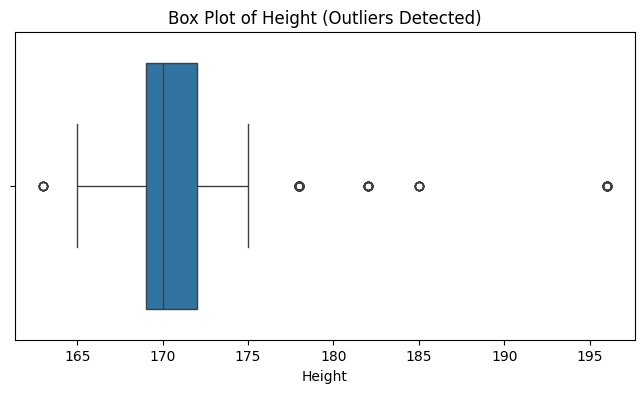


Column: Body mass index - No significant outliers detected.

Column: Absenteeism time in hours
  Q1: 2.0, Q3: 8.0, IQR: 6.0
  Lower Bound: -7.0, Upper Bound: 17.0
  Number of outliers: 44
  Outliers percentage: 5.95%


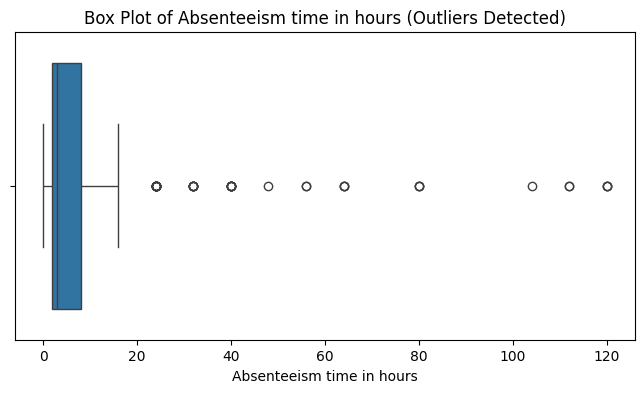

In [ ]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

print("Detecting outliers in numerical columns using IQR:")

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

    if not outliers.empty:
        print(f"\nColumn: {col}")
        print(f"  Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
        print(f"  Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
        print(f"  Number of outliers: {len(outliers)}")
        print(f"  Outliers percentage: {len(outliers) / len(df) * 100:.2f}%")

        # Visualize outliers with a box plot
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Box Plot of {col} (Outliers Detected)')
        plt.xlabel(col)
        plt.show()
    else:
        print(f"\nColumn: {col} - No significant outliers detected.")

**Reasoning**:
With outliers identified and visualized, the next step is to correct them by capping values at the IQR-defined upper and lower bounds, as per the main task's instructions for data cleaning.



In [ ]:
print("Correcting outliers by capping at IQR bounds:")

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    initial_outliers_count = len(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    if initial_outliers_count > 0:
        print(f"  Column: {col} - Capped {initial_outliers_count} outliers. New min: {df[col].min():.2f}, new max: {df[col].max():.2f}")
    else:
        print(f"  Column: {col} - No outliers to cap.")

print("\nOutlier correction complete.")

Correcting outliers by capping at IQR bounds:
  Column: ID - No outliers to cap.
  Column: Reason for absence - No outliers to cap.
  Column: Month of absence - No outliers to cap.
  Column: Day of the week - No outliers to cap.
  Column: Seasons - No outliers to cap.
  Column: Transportation expense - Capped 3 outliers. New min: 118.00, new max: 381.50
  Column: Distance from Residence to Work - No outliers to cap.
  Column: Service time - Capped 5 outliers. New min: 1.00, new max: 26.50
  Column: Age - Capped 8 outliers. New min: 27.00, new max: 53.50
  Column: Hit target - Capped 19 outliers. New min: 87.00, new max: 100.00
  Column: Disciplinary failure - Capped 40 outliers. New min: 0.00, new max: 0.00
  Column: Education - Capped 129 outliers. New min: 1.00, new max: 1.00
  Column: Son - No outliers to cap.
  Column: Social drinker - No outliers to cap.
  Column: Social smoker - Capped 54 outliers. New min: 0.00, new max: 0.00
  Column: Pet - Capped 46 outliers. New min: 0.00, ne

## Final Task

### Subtask:
Summarize the data cleaning steps performed, including how missing values and outliers were handled, and describe the state of the dataset after these corrections.


## Summary:

### Data Analysis Key Findings

*   **Missing Values**: No missing values were found in the dataset, rendering the imputation step unnecessary as there were no values to impute.
*   **Outlier Detection**: Outliers were identified in several numerical columns using the Interquartile Range (IQR) method. These columns included: `Transportation expense`, `Service time`, `Age`, `Hit target`, `Disciplinary failure`, `Education`, `Social smoker`, `Pet`, `Height`, and `Absenteeism time in hours`. Box plots were generated to visualize these outliers.
*   **Outlier Correction**: Outliers in the identified numerical columns were corrected by capping them at the IQR-defined upper and lower bounds. The process confirmed the number of outliers capped for each affected column and updated their minimum and maximum values.

### Insights or Next Steps

*   The dataset is now cleaned of both missing values (as none were present) and outliers in numerical columns, making it ready for further analysis or model training.
*   Consider investigating the nature of the identified outliers to understand if they represent true extreme events or data entry errors, which might inform future data collection strategies.
